<a href="https://colab.research.google.com/github/DaniyalK03/HPC/blob/main/HPC_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Techniques of High-Performance Computing (Assignment 4)

**Submission by SN: 21015796**

## Introduction

The following notebook is submitted coursework for PHAS0102.

This notebook utilises various libraries and discretises a space to solve the heat equation problem for a square plate with a single intially heated edge using:


*  Explicit Scheme - An implementation of the Forward Euler to evolve the heat ditribution for the system by setting up matrix equations for the differential operator and vector representing discretised points. CUDA is utilised to optimise the calculation using GPUs for high performance gains.

*   Implicit Scheme - An implementation of the Backward Euler to evolve the heat distribution for the system with a similar setup as the Explicit Scheme however utilise SciPy's spsolve function for sparse matrix solving for the same results.

Both Schemes are tested for stability across variation of the Courant number and are also tested for convergence to a true solution for time taken (t*) for the midpoint of plate to reach temperature = 1. The observations are noted as findings for the schemes.



### Bibliography

**[1]** A. Al-Refaie, "Assignment 2", *PHAS0102*, 2024

**[2]** 21015796, "Coursework 1", *PHAS0102*, 2024

## Explicit Scheme (Forward Euler)


First, Explicit Scheme is created then Implicit Scheme usinf Forwards and Backwards Euler respectively.

In [ ]:
###############################################################################
# Importing backend libraries as necessary

import numpy as np
import matplotlib.pyplot as plt
import scipy
import numba

from numba import njit, jit
from numba import cuda
from numpy.random import default_rng
from timeit import timeit
from scipy.sparse import coo_matrix, csr_matrix, linalg, diags
from scipy.stats import linregress
from scipy.sparse.linalg import cg,gmres
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
from scipy.sparse import lil_matrix, eye
from scipy.sparse.linalg import spsolve

In [ ]:
@njit(fastmath=True, parallel=True)
def explicit_heat(N,C):
  """
  This function uses the forward euler to model the heat distribution across the square plate
  Inputs: N = Given number of points for discretisation
          C = Courant Number

  Outputs:t* = Time taken for center to reach u = 1
          u = Heat distribution across plate
  """
  u = np.zeros((N+1, N+1))
  u[:,N] = 5.0 # Setting heated of square plate.
  h = 2.0 / N # 2 as range from -1 to 1
  dt = C * h**2

  x_axis = np.linspace(-1, 1, N+1)
  y_axis = np.linspace(-1, 1, N+1)

  # Setting integer midpoints
  i_mid = N//2
  j_mid = N//2

  time = 0.0
  time_limit = 1.0 # Limit to stop unecessary later calculations

  # Initialise empty arrays to store values later
  times = []
  max_temps = []

  # Only need to know when u = 1
  while u[i_mid, j_mid] < 1.0 and time < time_limit:
    times.append(time)
    max_temps.append(u.max())

    u_new = u.copy()

    # Calculate the interior points Laplacian evolution
    laplacian = (u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - 4*u[1:-1, 1:-1]) / (h**2)

    # Update interior values
    u_new[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*laplacian

    # Boundary Conditions

    u_new[:, N] = 5.0
    u_new[0, :] = 0.0
    u_new[N, :] = 0.0
    u_new[:, 0] = 0.0

    u = u_new
    time += dt # Update time step

  print(f"Approximate t* =", time)
  print(f"Center Value =", u[i_mid, j_mid])

  return(np.array(times), np.array(max_temps),u)

In [ ]:
def temp_plot(func, N, C):
  """
  This function plots the temperature across the square plate
  """

  x = np.linspace(-1, 1, N+1)
  y = np.linspace(-1, 1, N+1)
  u = func(N, C)[-1]

  X, Y = np.meshgrid(x, y)

  # Plotting and labelling temperature evolution for 3D system.
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')

  surf = ax.plot_surface(X, Y, u.T, cmap='plasma', edgecolor='none') # Transposed to better display problem

  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('u(x,y)')
  ax.set_title('Solution of the Heat Equation')

  # Adding colour bar.
  fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

  plt.show()

Approximate t* = 0.4240062499998455
Center Value = 1.0000015997062328


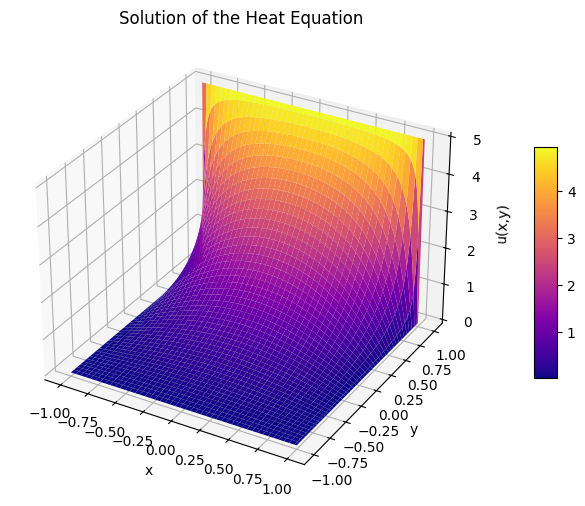

In [ ]:
temp_plot(explicit_heat, 400, 0.25)

It can be seen that the evolution of the heat is as expected, over time being distributed evenly from the initially heat edge (the top edge in this case). This means we have modelled the heat equation and discretised the plate correctly.

In [ ]:
def stability_test(func1, N, C_array):
  """
  This function determines if a given scheme is stable for a particular value of N and the Courant Number.
  """
  fin_times = []
  for Courant in C_array:
    print(f"\nTesting with C = {Courant:.3f} (Threshold C = 0.250)")
    times, max_vals, u_vals = func1(N, Courant);

    #print("Final time:", times[-1])
    print("Final max(u):", max_vals[-1])

    if max_vals[-1] > 1e3:  # Test divergence
        print(f"The solution diverges indicating scheme instability with N = {N} at C = {Courant:.3f}")
    else:
        print(f"The solution remains bounded therefore scheme stability with N = {N} at C = {Courant:.3f}")
    fin_times.append(times[-1])
  return(fin_times)


In [ ]:
C_test = 0.25
C_test_array = [0.5*C_test, C_test, 2*C_test]
stability_test(explicit_heat, 400, C_test_array);



Testing with C = 0.125 (Threshold C = 0.250)
Approximate t* = 0.42400937499942865
Center Value = 1.000001434062715
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 400 at C = 0.125

Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.4240062499998455
Center Value = 1.0000015997062328
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 400 at C = 0.250

Testing with C = 0.500 (Threshold C = 0.250)
Approximate t* = 0.005012500000000015
Center Value = 79.14254794549159
Final max(u): 1.446929892415234e+185
The solution diverges indicating scheme instability with N = 400 at C = 0.500


We can clearly see that Courant number, $C \leq \frac{1}{4}$, is required for stability and there is a sharp divergence in the solutions if this limit is exceeded. It can be seen that C = 0.25 is the most accurate hence this is used for testing beyond this point.

In [ ]:
def heat_tester(func1, N_array, C_array):
  """
  This function tests the scheme across a range of N values at a selected Courant
  number to determine the time taken for the center of plate to reach u = 1 and
  the convergence of residuals to the true t* value.
  """
  N_times = []
  for N in N_array:
    time_output = stability_test(func1, N, C_array);
    N_times.append(time_output)

  N_times = np.array(N_times).flatten()
  N_residuals = abs(N_times - 0.424011387033)
  compare = np.ones(int(len(N_array))) * 0.424011387033

  plt.figure()
  plt.plot(N_array, N_times, "x-", label="t*")
  plt.plot(N_array, compare, ".-", label="True t*")
  plt.xlabel("Discretisation of N points ((N+1)^2 x (N+1)^2 grid)")
  plt.ylabel("Time (seconds)")
  plt.title("Time taken for centre to reach u = 1 for given N")
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure()
  plt.plot(N_array, N_residuals, "x-", label="t* - True t*")
  plt.xlabel("Discretisation of N points ((N+1)^2 x (N+1)^2 grid)")
  plt.ylabel("Convergence (seconds)")
  plt.xscale("log")
  plt.yscale("log")
  plt.title("Convergence to true time value for given N")
  plt.legend()
  plt.grid()
  plt.show()


Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.4200000000000003
Center Value = 1.0076478570975351
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 10 at C = 0.250

Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.4225000000000003
Center Value = 1.0013241128212353
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 20 at C = 0.250

Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.423600000000008
Center Value = 1.0000008263301452
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 50 at C = 0.250

Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.4239999999999696
Center Value = 1.0001128751519923
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 100 at C = 0.250

Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.4239999999999574
Center Value = 1.0000176929727613
Final max(u): 5.0
The so

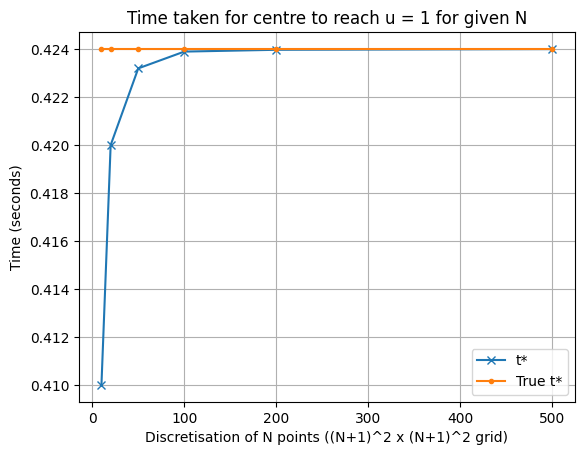

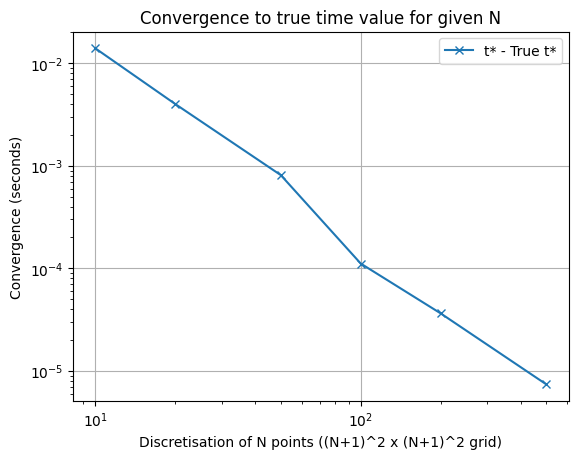

In [ ]:
heat_tester(explicit_heat,[10, 20, 50, 100, 200, 500], [0.25])

It can be seen clearly that the explicit scheme functions well, being able to calculate stable solutions relatively quickly for discretisations up to N=500 and reaching accuracy up to 5 decimal places at a Courant Number = 0.25

##Explicit CUDA Scheme (Forward Euler)

In [ ]:

@cuda.jit
def explicit_update_kernel(u, u_new, N, h, dt):
    """
    This functions sets up the updating kernel to be called later.
    """
    # Thread indices
    i, j = cuda.grid(2)

    # Update interior points
    if i >= 1 and i <= N-1 and j >= 1 and j <= N-1:

        # Calculate Laplacian for interior points
        laplacian = (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] - 4*u[i,j])/(h*h)
        u_new[i,j] = u[i,j] + dt*laplacian # Update the values

def explicit_heat_cuda(N, C):
    """
    This function uses the forward euler to model the heat distribution across the square plate but using the GPU now
    Inputs: N = Given number of points for discretisation
          C = Courant Number

    Outputs:t* = Time taken for center to reach u = 1
          u = Heat distribution across plate
    """
    # Initialising with a single heated edge
    u = np.zeros((N+1, N+1), dtype=np.float32)
    u[:, N] = 5.0
    h = 2.0 / N # Using L = 2 again
    dt = C * h**2

    # Midpoint of square plate
    i_mid = N//2
    j_mid = N//2

    time = 0.0
    time_limit = 1.0 # Limit to minimise further unecessary calcualtions

    # Allocate and copy data to GPU
    u_gpu = cuda.to_device(u)
    u_new_gpu = cuda.to_device(u)  # Updated values

    # Setting up grid, block and threads
    threadsperblock = (16,16)
    blockspergrid_x = (N+1 + threadsperblock[0]-1) // threadsperblock[0]
    blockspergrid_y = (N+1 + threadsperblock[1]-1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Time-stepping
    while True:
        # Use kernel from above
        explicit_update_kernel[blockspergrid, threadsperblock](u_gpu, u_new_gpu, N, h, dt)

        # Update boundary conditions on GPU
        u = u_new_gpu.copy_to_host()

        # Apply boundaries on CPU, same as earlier
        u[:, N] = 5.0
        u[0, :] = 0.0
        u[N, :] = 0.0
        u[:, 0] = 0.0

        # Copy updated u back to GPU
        u_gpu = cuda.to_device(u)
        u_new_gpu = cuda.to_device(u)

        # Check center u = 1 reached or time limit reached
        if u[i_mid, j_mid] >= 1.0 or time >= time_limit:
            break

        time += dt # Update time step

    print("Approximate t* =", time)
    print("Center Value =", u[i_mid, j_mid])
    return time, u, u

Approximate t* = 0.4240062499998455
Center Value = 1.0000019


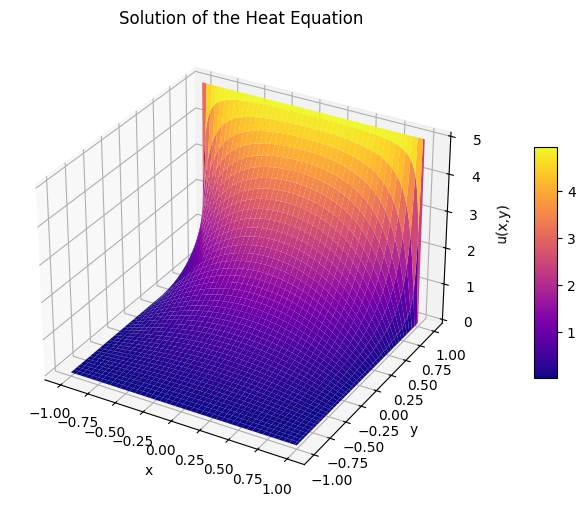

In [ ]:
temp_plot(explicit_heat_cuda, 400, 0.25)

It can be seen that the evolution of the heat is as expected, over time being distributed evenly from the initially heat edge (the top edge in this case). This means we have modelled the heat equation and discretised the plate correctly.

In [ ]:
stability_test(explicit_heat_cuda, 100, C_test_array);


Testing with C = 0.125 (Threshold C = 0.250)


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Approximate t* = 0.42394999999996147
Center Value = 1.0000535
Final max(u): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

We can clearly see that Courant number, $C \leq \frac{1}{4}$, is required for stability and there is a sharp divergence in the solutions if this limit is exceeded. It can be seen that C = 0.25 is the most accurate hence this is used for testing beyond this point.

In [ ]:
heat_tester(explicit_heat_cuda,[10, 20, 50, 100, 200, 500], [0.25])


Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.4100000000000003
Center Value = 1.0076479
Final max(u): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

It can be seen clearly that the explicit scheme functions well, being able to calculate stable solutions relatively quickly for discretisations up to N=500 and reaching accuracy up to 5 decimal places at a Courant Number = 0.25

##Implicit Scheme (Backward Euler)

In [ ]:

def implicit_heat(N, C):
  """
  This function uses the backward euler to model the heat distribution across the square plate
  Inputs: N = Given number of points for discretisation
          C = Courant Number

  Outputs:t* = Time taken for center to reach u = 1
          u = Heat distribution across plate
  """
  # Setup grid and parameters
  h = 2.0 / N
  dt = C * h**2
  x_axis = np.linspace(-1, 1, N+1)
  y_axis = np.linspace(-1, 1, N+1)

  # Initialize solution array u
  u = np.zeros((N+1, N+1))

  # Set up single heated edge
  u[:,N] = 5.0

  # Midpoints
  i_mid = N//2
  j_mid = N//2

  # Number of interior points is (N-1)*(N-1)
  M = (N-1)*(N-1)

  def idx(i,j):
    return (j-1)*(N-1) + (i-1)

    # Build Laplacian matrix for interior points
  A = lil_matrix((M,M))
  F = np.zeros(M)  # For boundary contributions

  for i in range(1,N):
    for j in range(1,N):
      p = idx(i,j)

      # Setting up the discretised from all edges

      A[p,p] = -4.0/(h*h)
      if i+1 <= N-1:
        A[p, idx(i+1,j)] = 1.0/(h*h)
      else:
        F[p] += 5.0/(h*h) # Heated edge

      if i-1 >= 1:
        A[p, idx(i-1,j)] = 1.0/(h*h)
      else:
        pass

      if j+1 <= N-1:
        A[p, idx(i,j+1)] = 1.0/(h*h)
      else:
        pass

      if j-1 >= 1:
        A[p, idx(i,j-1)] = 1.0/(h*h)
      else:
        pass

  A = A.tocsr()
  I = eye(M, format='csr')
  M_mat = (I - dt*A)

  time = 0.0
  time_limit = 1.0 # Time limit to stop unecessary further calculations

  # Initialise arrays to store results later
  times = []
  max_temps = []

  # Until center reaches u = 1 or time steps to time limit reached
  while u[i_mid, j_mid] < 1.0 and time < time_limit:
    times.append(time)
    max_temps.append(u.max())

  # Flatten interior points into a vector
    U_int = u[1:-1, 1:-1].flatten()

  # Construct RHS
    RHS = U_int + dt*F

  # Solve linear system using sparse solver
    U_int_new = spsolve(M_mat, RHS)

  # Put interior points back into u
    u[1:-1,1:-1] = U_int_new.reshape((N-1,N-1))

  # Re-apply boundary conditions
    u[:,N] = 5.0
    u[0,:] = 0.0
    u[:,0] = 0.0
    u[N,:] = 0.0

    time += dt # Update time

  print("Approximate t* =", time)
  print("Center Value =", u[i_mid, j_mid])

  return np.array(times), np.array(max_temps), u


Approximate t* = 0.42480000000000806
Center Value = 1.0004507454428764


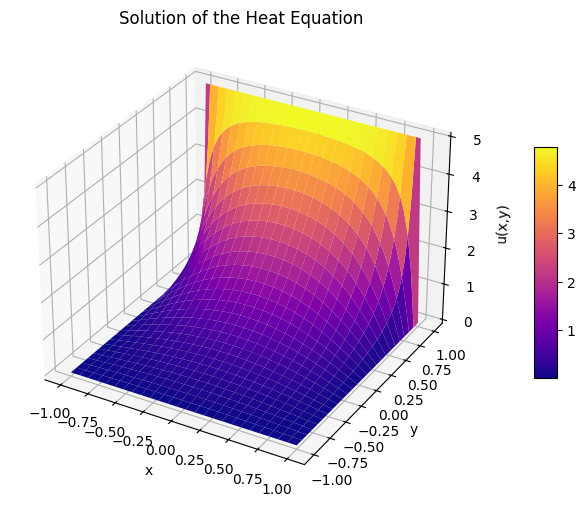

In [ ]:
temp_plot(implicit_heat, 50, 0.25) # Implicit Scheme is more time consuming thus N=50 used.

It can be seen that the evolution of the heat is as expected, over time being distributed evenly from the initially heat edge (the top edge in this case). This means we have modelled the heat equation and discretised the plate correctly.

In [ ]:
stability_test(implicit_heat, 50, C_test_array);


Testing with C = 0.125 (Threshold C = 0.250)
Approximate t* = 0.4243999999999859
Center Value = 1.0002152527764807
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 50 at C = 0.125

Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.42480000000000806
Center Value = 1.0004507454428764
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 50 at C = 0.250

Testing with C = 0.500 (Threshold C = 0.250)
Approximate t* = 0.425600000000004
Center Value = 1.00092064491661
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 50 at C = 0.500


It can be seen that the Implicit Scheme appears stable at a large range of Courant Numbers unlike the Explicit Scheme. It also appears that a smaller Courant Number ($C < \frac{1}{4}$) is more accurate however to enable direct comparison to the Explicit Scheme, C = 0.25 is still used in testing.


Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.44000000000000034
Center Value = 1.00666006142287
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 10 at C = 0.250

Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.4275000000000003
Center Value = 1.0010517418709795
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 20 at C = 0.250

Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.42480000000000806
Center Value = 1.0004507454428764
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 50 at C = 0.250

Testing with C = 0.250 (Threshold C = 0.250)
Approximate t* = 0.4241999999999696
Center Value = 1.000102269698428
Final max(u): 5.0
The solution remains bounded therefore scheme stability with N = 100 at C = 0.250


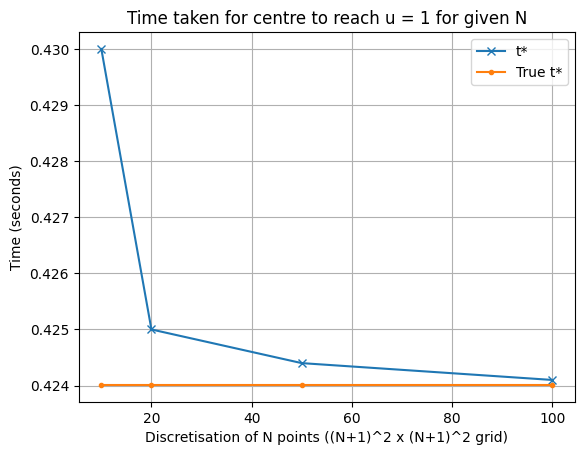

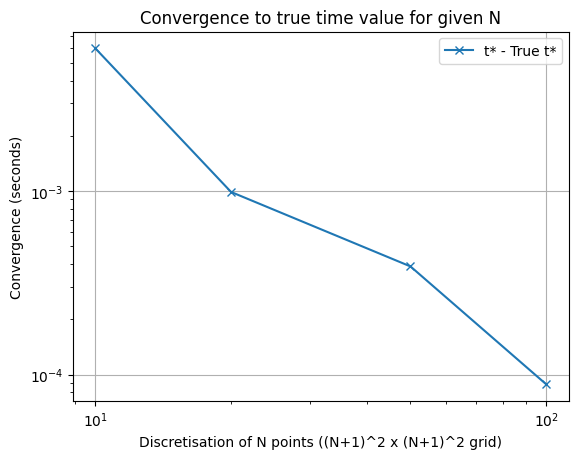

In [ ]:
heat_tester(implicit_heat, [10, 20, 50, 100], [0.25])

Due to performance constraints in time taken to actually run the testing, only up to N=100 is tested here. It should be noted that the Implicit Scheme is slightly more accurate here as it achieves a convergence less than $10^{-4}$ whereas the Explicit Scheme has a convergence value slightly greater than $10^{-4}$. It can be assumed with a smaller Courant Number, the accuracy would also be greater at larger N values yet this is at the cost of wall time.